In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import cv2

import os, glob

In [2]:
img_dir = sorted(glob.glob('D:/dataset/kitti/data_road/data_road/training/image_2/*.png'))
mask_dir = sorted(glob.glob('D:/dataset/kitti/data_road/data_road/training/gt_image_2/*.png'))
print(len(img_dir), len(mask_dir))

289 289


In [3]:
from tqdm import tqdm_notebook

total1 = tqdm_notebook(img_dir)
total2 = tqdm_notebook(mask_dir)

height = 256
width = 1024

image = []
mask = []

for img_path in img_dir:    
        
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img = np.transpose(img, (2, 0, 1)) / 255
    image.append(img)

for mask_path in mask_dir:    
        
    img = cv2.imread(mask_path, 1)
    lower = np.array([254, 0, 254], dtype="uint8")
    upper = np.array([255, 0, 255], dtype="uint8")

    masks = cv2.inRange(img, lower, upper)
    output = cv2.bitwise_and(img, img, mask=masks)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(output, (width, height), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(1, height, width) / 255
    mask.append(img)
        

image = np.array(image)
mask = np.array(mask)
print(image.shape, mask.shape)

with open('./pickle/image_train.p', 'wb') as f:
    pickle.dump(image, f, protocol=4)

with open('./pickle/mask_labels.p', 'wb') as f:
    pickle.dump(mask, f, protocol=4)

(289, 3, 256, 1024) (289, 1, 256, 1024)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [5]:
x_train  =  torch.FloatTensor(image)
y_train  =  torch.FloatTensor(mask)

In [6]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [259, 30])

In [7]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

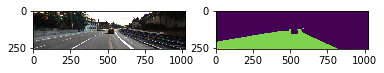

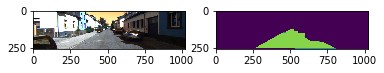

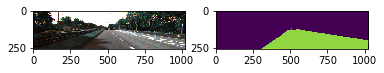

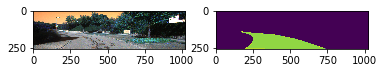

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

dataiter = iter(train_loader)
images, labels = dataiter.next()

show_img = (np.transpose(images, (0, 2, 3, 1))).numpy()
show_label = (np.transpose(labels, (0, 2, 3, 1))).numpy()

for i in range(4):
    fig = plt.figure()
    
    npimg = show_img[i]
    nplabel = show_label[i]
    nplabel = nplabel.squeeze()
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(npimg)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(nplabel)
    plt.show()

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 5, padding=2)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 128, 5, padding=2)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.dense = nn.Conv2d(128, 128, 1)
        
        self.up5 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.up6 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.up7 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(64, 32, 3, padding=1)
        
        self.up8 = nn.Upsample(scale_factor=2)
        self.conv8 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = self.dense(x)
        
        x = self.conv5(F.relu(self.up5(x)))
        x = self.conv6(F.relu(self.up6(x)))
        x = self.conv7(F.relu(self.up7(x)))
        x = self.conv8(F.relu(self.up8(x)))
        return x


net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (up5): Upsample(scale_factor=2.0, mode=nearest)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Upsample(scale_factor=2.0, mode=nearest)
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up7): Upsample(sca

In [10]:
import torch.optim as optim

criterion = nn.MSELoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [11]:
train_losses, val_losses, accuracy = [], [], []
epochs = 20

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():
            cnt = 0
            
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_outputs = net(val_image)
                
                val_loss += criterion(val_outputs, val_label)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} ".format(val_loss/len(val_loader))
             )

print('Finished Training')

Epoch: 1/20 ||  Training Loss: 0.03250 ||  Val Loss: 0.02576 
Epoch: 2/20 ||  Training Loss: 0.02373 ||  Val Loss: 0.02312 
Epoch: 3/20 ||  Training Loss: 0.02024 ||  Val Loss: 0.01870 
Epoch: 4/20 ||  Training Loss: 0.01248 ||  Val Loss: 0.01051 
Epoch: 5/20 ||  Training Loss: 0.00932 ||  Val Loss: 0.00806 
Epoch: 6/20 ||  Training Loss: 0.00932 ||  Val Loss: 0.00794 
Epoch: 7/20 ||  Training Loss: 0.00844 ||  Val Loss: 0.00915 
Epoch: 8/20 ||  Training Loss: 0.00895 ||  Val Loss: 0.00701 
Epoch: 9/20 ||  Training Loss: 0.00796 ||  Val Loss: 0.00721 
Epoch: 10/20 ||  Training Loss: 0.00746 ||  Val Loss: 0.00707 
Epoch: 11/20 ||  Training Loss: 0.00788 ||  Val Loss: 0.00662 
Epoch: 12/20 ||  Training Loss: 0.00725 ||  Val Loss: 0.00678 
Epoch: 13/20 ||  Training Loss: 0.00700 ||  Val Loss: 0.00679 
Epoch: 14/20 ||  Training Loss: 0.00712 ||  Val Loss: 0.00618 
Epoch: 15/20 ||  Training Loss: 0.00702 ||  Val Loss: 0.00574 
Epoch: 16/20 ||  Training Loss: 0.00693 ||  Val Loss: 0.00675 
E

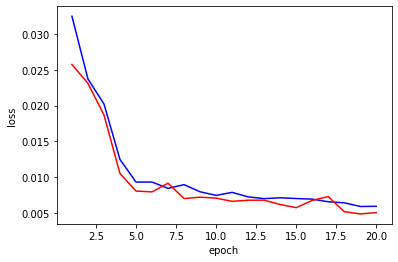

In [14]:
x = np.arange(1, 21, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

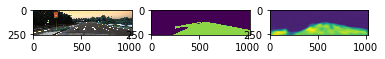

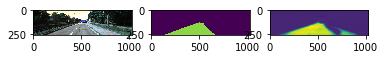

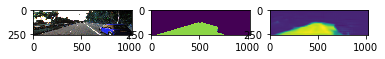

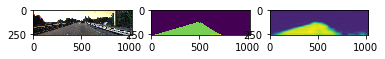

In [15]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

show_img = (np.transpose(images, (0, 2, 3, 1))).numpy()
show_label = (np.transpose(labels, (0, 2, 3, 1))).numpy()

inputs, labels = images.to(device), labels.to(device)
outputs = net(inputs)
show_out = (np.transpose(outputs.detach().cpu(), (0, 2, 3, 1))).numpy()

for i in range(len(images)):
    fig = plt.figure()
    
    npimg = show_img[i]
    nplabel = show_label[i]
    nplabel = nplabel.squeeze()
    npout = show_out[i]
    npout = npout.squeeze()
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(npimg)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(nplabel)
    ax2 = fig.add_subplot(1,3,3)
    ax2.imshow(npout)
    plt.show()